# Modelo No Supervisado para Análisis de Patrones de Estrés

PROYECTO: Sistema Inteligente de Predicción Temprana de Enfermedades Crónicas
MODELO: Análisis No Supervisado de Patrones de Estrés
OBJETIVO: Identificar grupos naturales de pacientes según sus niveles y patrones de estrés

Técnicas utilizadas:
- K-Means Clustering
- Hierarchical Clustering
- DBSCAN
- Análisis de Componentes Principales (PCA)

Variables para análisis de estrés:
- Nivel_estres (variable principal)
- Frecuencia_cardiaca (indicador fisiológico de estrés)
- Presion_sistolica (respuesta cardiovascular al estrés)
- Variabilidad_ritmo (sistema nervioso autónomo)
- Temperatura (respuesta termorregulatoria)

### 1. IMPORTACIÓN DE LIBRERÍAS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### 2. CARGA Y PREPARACIÓN DE DATOS

In [11]:
print("CARGA Y PREPARACIÓN DE DATOS PARA ANÁLISIS DE ESTRÉS")
print("="*60)

# Cargar el dataset limpio
try:
    df = pd.read_csv('../preprocessing/data/processed/mediciones_cardiacas_clean.csv')
    print("✅ Dataset cargado exitosamente")
    print(f" Dimensiones del dataset: {df.shape}")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo 'mediciones_cardiacas_limpio.csv'")



CARGA Y PREPARACIÓN DE DATOS PARA ANÁLISIS DE ESTRÉS
✅ Dataset cargado exitosamente
 Dimensiones del dataset: (6587, 11)


In [15]:
# Variables relacionadas con el estrés
# El estrés afecta múltiples sistemas fisiológicos
variables_estres = [
    'Nivel_estres',          # Variable principal de estrés
    'Frecuencia_cardiaca',   # El estrés aumenta la FC
    'Presion_sistolica',     # El estrés eleva la presión arterial
    'Variabilidad_ritmo',    # El estrés reduce la variabilidad cardíaca
    'Temperatura'            # El estrés puede afectar la temperatura corporal
]

print(f"\n Variables seleccionadas para análisis de estrés:")
for i, var in enumerate(variables_estres, 1):
    print(f"   {i}. {var}")

# Filtrar datos para análisis
df_estres = df[variables_estres].copy()

print(f"\n Dataset para análisis de estrés:")
print(f"   • Muestras: {len(df_estres)}")
print(f"   • Variables: {len(variables_estres)}")

# Verificar datos faltantes
print(f"\n Valores faltantes por variable:")
for var in variables_estres:
    missing = df_estres[var].isnull().sum()
    print(f"   • {var}: {missing} ({missing/len(df_estres)*100:.1f}%)")



 Variables seleccionadas para análisis de estrés:
   1. Nivel_estres
   2. Frecuencia_cardiaca
   3. Presion_sistolica
   4. Variabilidad_ritmo
   5. Temperatura

 Dataset para análisis de estrés:
   • Muestras: 6587
   • Variables: 5

 Valores faltantes por variable:
   • Nivel_estres: 0 (0.0%)
   • Frecuencia_cardiaca: 0 (0.0%)
   • Presion_sistolica: 0 (0.0%)
   • Variabilidad_ritmo: 0 (0.0%)
   • Temperatura: 0 (0.0%)


In [17]:
# Estadísticas descriptivas básicas
print(f"\n Estadísticas descriptivas:")
print(df_estres.describe().round(2))


 Estadísticas descriptivas:
       Nivel_estres  Frecuencia_cardiaca  Presion_sistolica  \
count       6587.00              6587.00            6587.00   
mean           7.09                69.00             111.80   
std            2.32                14.62              14.87   
min            0.00                45.00              82.00   
25%            5.00                58.00             101.00   
50%            7.00                66.00             110.00   
75%            9.00                78.00             120.00   
max           10.00               123.00             185.00   

       Variabilidad_ritmo  Temperatura  
count             6587.00      6587.00  
mean                33.87        36.51  
std                 10.48         0.50  
min                  6.22        35.20  
25%                 26.25        36.10  
50%                 33.00        36.50  
75%                 41.07        36.80  
max                 77.79        38.10  


### 3. ANÁLISIS EXPLORATORIO ESPECÍFICO PARA ESTRÉS

ANÁLISIS EXPLORATORIO - PATRONES DE ESTRÉS


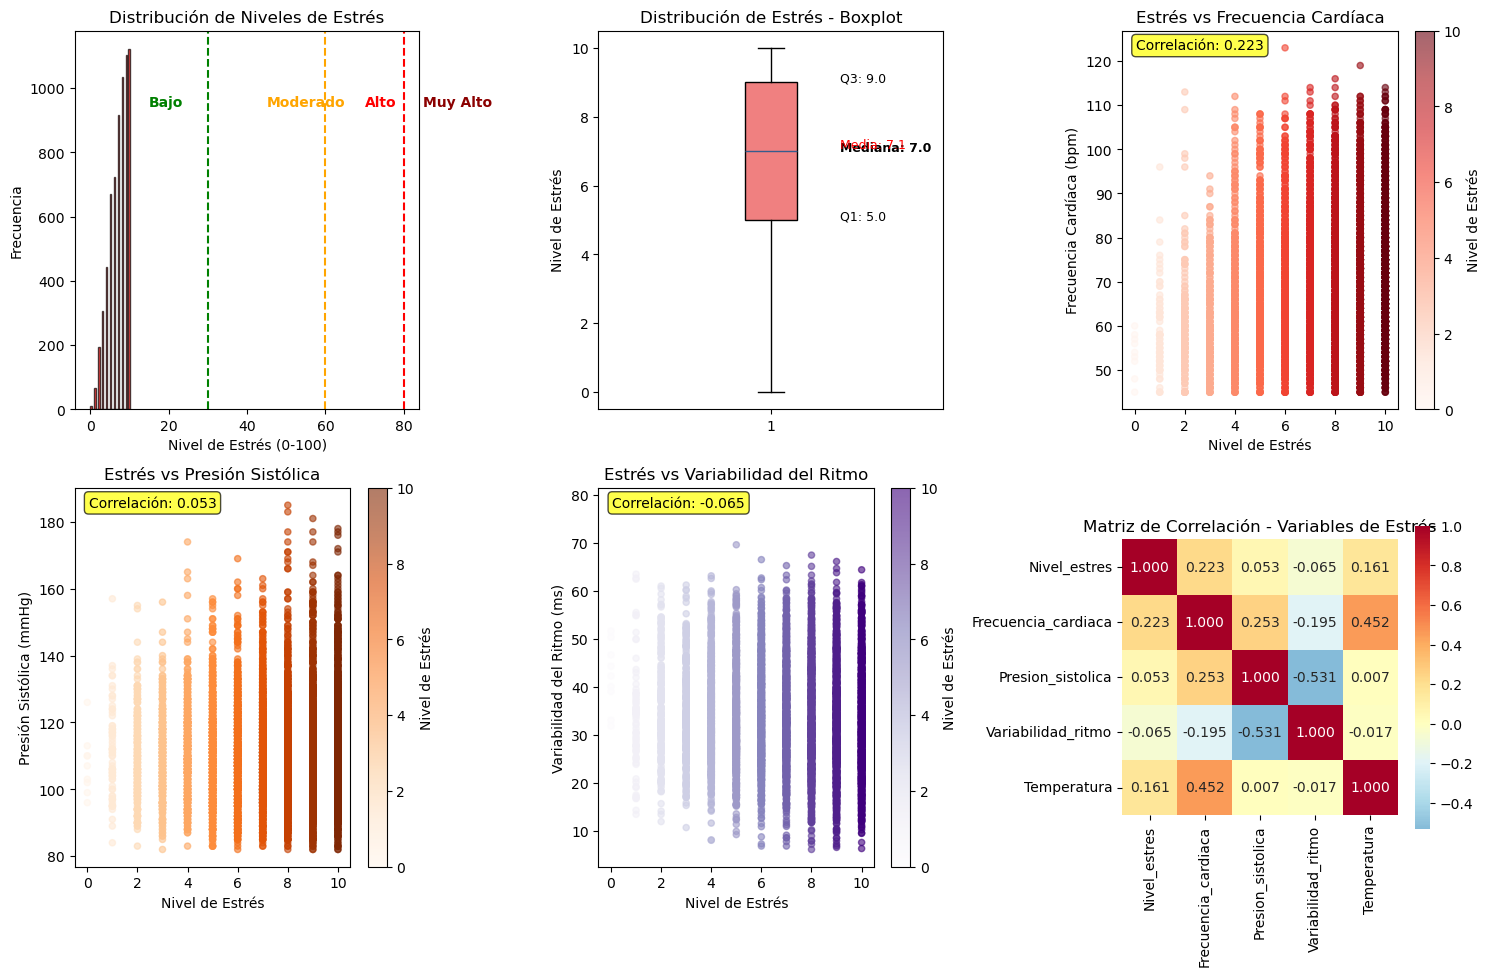


 Análisis de correlaciones con el nivel de estrés:
   • Frecuencia_cardiaca: 0.223 (Correlación débil)
   • Presion_sistolica: 0.053 (Correlación muy débil)
   • Variabilidad_ritmo: -0.065 (Correlación muy débil)
   • Temperatura: 0.161 (Correlación muy débil)


In [22]:
print("ANÁLISIS EXPLORATORIO - PATRONES DE ESTRÉS")
print("="*60)

# Gráfico 1: Distribución de niveles de estrés
plt.figure(figsize=(15, 10))

# Subplot 1: Histograma de nivel de estrés
plt.subplot(2, 3, 1)
plt.hist(df_estres['Nivel_estres'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribución de Niveles de Estrés')
plt.xlabel('Nivel de Estrés (0-100)')
plt.ylabel('Frecuencia')

# Agregar líneas de referencia para niveles de estrés
plt.axvline(30, color='green', linestyle='--', label='Bajo (0-30)')
plt.axvline(60, color='orange', linestyle='--', label='Moderado (30-60)')
plt.axvline(80, color='red', linestyle='--', label='Alto (60-80)')
plt.text(15, plt.ylim()[1]*0.8, 'Bajo', color='green', fontweight='bold')
plt.text(45, plt.ylim()[1]*0.8, 'Moderado', color='orange', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, 'Alto', color='red', fontweight='bold')
plt.text(85, plt.ylim()[1]*0.8, 'Muy Alto', color='darkred', fontweight='bold')

# Subplot 2: Boxplot de nivel de estrés
plt.subplot(2, 3, 2)
box_plot = plt.boxplot(df_estres['Nivel_estres'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
plt.title('Distribución de Estrés - Boxplot')
plt.ylabel('Nivel de Estrés')

# Calcular estadísticas del estrés
q1 = df_estres['Nivel_estres'].quantile(0.25)
q2 = df_estres['Nivel_estres'].median()
q3 = df_estres['Nivel_estres'].quantile(0.75)
mean_stress = df_estres['Nivel_estres'].mean()

plt.text(1.2, q1, f'Q1: {q1:.1f}', fontsize=9)
plt.text(1.2, q2, f'Mediana: {q2:.1f}', fontsize=9, fontweight='bold')
plt.text(1.2, q3, f'Q3: {q3:.1f}', fontsize=9)
plt.text(1.2, mean_stress, f'Media: {mean_stress:.1f}', fontsize=9, color='red')

# Subplot 3: Correlación entre estrés y frecuencia cardíaca
plt.subplot(2, 3, 3)
plt.scatter(df_estres['Nivel_estres'], df_estres['Frecuencia_cardiaca'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Reds')
plt.colorbar(label='Nivel de Estrés')
plt.title('Estrés vs Frecuencia Cardíaca')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Frecuencia Cardíaca (bpm)')

# Calcular y mostrar correlación
corr_stress_hr = df_estres['Nivel_estres'].corr(df_estres['Frecuencia_cardiaca'])
plt.text(0.05, 0.95, f'Correlación: {corr_stress_hr:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 4: Correlación entre estrés y presión sistólica
plt.subplot(2, 3, 4)
plt.scatter(df_estres['Nivel_estres'], df_estres['Presion_sistolica'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Oranges')
plt.colorbar(label='Nivel de Estrés')
plt.title('Estrés vs Presión Sistólica')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Presión Sistólica (mmHg)')

corr_stress_bp = df_estres['Nivel_estres'].corr(df_estres['Presion_sistolica'])
plt.text(0.05, 0.95, f'Correlación: {corr_stress_bp:.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 5: Correlación entre estrés y variabilidad del ritmo
plt.subplot(2, 3, 5)
plt.scatter(df_estres['Nivel_estres'], df_estres['Variabilidad_ritmo'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Purples')
plt.colorbar(label='Nivel de Estrés')
plt.title('Estrés vs Variabilidad del Ritmo')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Variabilidad del Ritmo (ms)')

corr_stress_hrv = df_estres['Nivel_estres'].corr(df_estres['Variabilidad_ritmo'])
plt.text(0.05, 0.95, f'Correlación: {corr_stress_hrv:.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 6: Matriz de correlación
plt.subplot(2, 3, 6)
correlation_matrix = df_estres.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlación - Variables de Estrés')

plt.tight_layout()
plt.show()

# Análisis de correlaciones
print(f"\n Análisis de correlaciones con el nivel de estrés:")
for var in variables_estres[1:]:  # Excluir nivel_estres de la comparación consigo mismo
    corr = df_estres['Nivel_estres'].corr(df_estres[var])
    interpretacion = ""
    if abs(corr) > 0.7:
        interpretacion = "Correlación fuerte"
    elif abs(corr) > 0.4:
        interpretacion = "Correlación moderada"
    elif abs(corr) > 0.2:
        interpretacion = "Correlación débil"
    else:
        interpretacion = "Correlación muy débil"
    
    print(f"   • {var}: {corr:.3f} ({interpretacion})")


### 4. NORMALIZACIÓN DE DATOS

In [25]:
print("NORMALIZACIÓN DE DATOS")
print("="*60)

# Usar StandardScaler para normalizar (media=0, std=1)
# Esto es importante porque las variables tienen diferentes escalas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_estres)

# Crear DataFrame con datos normalizados para mejor visualización
df_estres_scaled = pd.DataFrame(X_scaled, columns=variables_estres)

print("✅ Datos normalizados con StandardScaler")
print(" Estadísticas después de normalización:")
print(df_estres_scaled.describe().round(3))

# Verificar que la normalización fue correcta (media ≈ 0, std ≈ 1)
print(f"\n Verificación de normalización:")
for var in variables_estres:
    mean_val = df_estres_scaled[var].mean()
    std_val = df_estres_scaled[var].std()
    print(f"   • {var}: Media = {mean_val:.3f}, Std = {std_val:.3f}")


NORMALIZACIÓN DE DATOS
✅ Datos normalizados con StandardScaler
 Estadísticas después de normalización:
       Nivel_estres  Frecuencia_cardiaca  Presion_sistolica  \
count      6587.000             6587.000           6587.000   
mean         -0.000               -0.000             -0.000   
std           1.000                1.000              1.000   
min          -3.053               -1.641             -2.004   
25%          -0.899               -0.752             -0.726   
50%          -0.037               -0.205             -0.121   
75%           0.825                0.616              0.551   
max           1.256                3.693              4.922   

       Variabilidad_ritmo  Temperatura  
count            6587.000     6587.000  
mean                0.000       -0.000  
std                 1.000        1.000  
min                -2.640       -2.621  
25%                -0.728       -0.823  
50%                -0.083       -0.023  
75%                 0.687        0.576  
m

### 5. DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS

DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS
🔄 Evaluando diferentes números de clusters...
   K=2: Silhouette=0.225, Calinski-Harabasz=2122.2, Davies-Bouldin=1.670
   K=3: Silhouette=0.214, Calinski-Harabasz=1931.1, Davies-Bouldin=1.466
   K=4: Silhouette=0.204, Calinski-Harabasz=1836.0, Davies-Bouldin=1.470
   K=5: Silhouette=0.186, Calinski-Harabasz=1653.1, Davies-Bouldin=1.421
   K=6: Silhouette=0.184, Calinski-Harabasz=1549.9, Davies-Bouldin=1.490
   K=7: Silhouette=0.173, Calinski-Harabasz=1452.9, Davies-Bouldin=1.533
   K=8: Silhouette=0.169, Calinski-Harabasz=1349.5, Davies-Bouldin=1.561
   K=9: Silhouette=0.165, Calinski-Harabasz=1276.9, Davies-Bouldin=1.571
   K=10: Silhouette=0.163, Calinski-Harabasz=1213.0, Davies-Bouldin=1.562


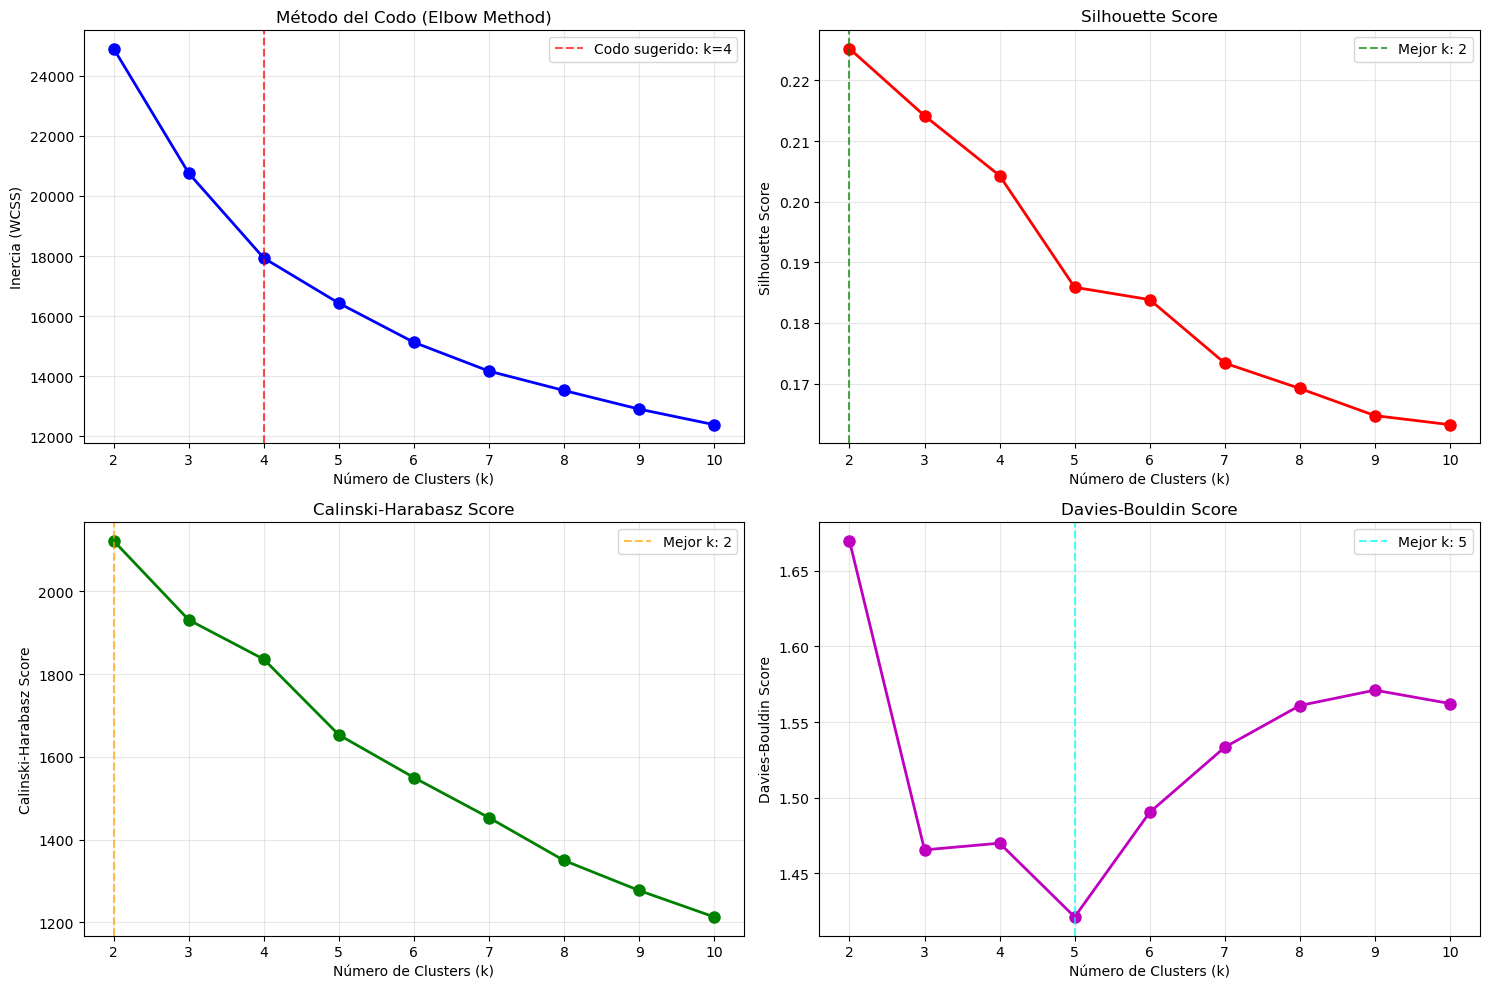


 Recomendaciones para número de clusters:
   • Método del codo: k = 4
   • Mejor Silhouette Score: k = 2 (Score: 0.225)
   • Mejor Calinski-Harabasz: k = 2 (Score: 2122.2)
   • Mejor Davies-Bouldin: k = 5 (Score: 1.421)

 Número óptimo de clusters seleccionado: k = 2


In [28]:
print("DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
print("="*60)

# Método del codo (Elbow Method) y Silhouette Score
k_range = range(2, 11)  # Evaluar de 2 a 10 clusters
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("🔄 Evaluando diferentes números de clusters...")

for k in k_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Métricas de evaluación
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
    
    print(f"   K={k}: Silhouette={silhouette_scores[-1]:.3f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.1f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

# Gráfico 2: Métricas para selección de clusters
plt.figure(figsize=(15, 10))

# Método del codo
plt.subplot(2, 2, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.grid(True, alpha=0.3)

# Encontrar el "codo" (punto de mayor curvatura)
differences = np.diff(inertias)
second_differences = np.diff(differences)
elbow_point = k_range[np.argmax(second_differences) + 1]
plt.axvline(elbow_point, color='red', linestyle='--', alpha=0.7, 
           label=f'Codo sugerido: k={elbow_point}')
plt.legend()

# Silhouette Score
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

# Marcar el mejor silhouette score
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
plt.axvline(best_k_silhouette, color='green', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_silhouette}')
plt.legend()

# Calinski-Harabasz Score
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
plt.title('Calinski-Harabasz Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True, alpha=0.3)

best_k_calinski = k_range[np.argmax(calinski_scores)]
plt.axvline(best_k_calinski, color='orange', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_calinski}')
plt.legend()

# Davies-Bouldin Score (menor es mejor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
plt.title('Davies-Bouldin Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True, alpha=0.3)

best_k_davies = k_range[np.argmin(davies_bouldin_scores)]
plt.axvline(best_k_davies, color='cyan', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_davies}')
plt.legend()

plt.tight_layout()
plt.show()

# Determinar el número óptimo de clusters
print(f"\n Recomendaciones para número de clusters:")
print(f"   • Método del codo: k = {elbow_point}")
print(f"   • Mejor Silhouette Score: k = {best_k_silhouette} (Score: {max(silhouette_scores):.3f})")
print(f"   • Mejor Calinski-Harabasz: k = {best_k_calinski} (Score: {max(calinski_scores):.1f})")
print(f"   • Mejor Davies-Bouldin: k = {best_k_davies} (Score: {min(davies_bouldin_scores):.3f})")

# Seleccionar k óptimo (mayoría de votos o Silhouette como criterio principal)
k_optimal = best_k_silhouette
print(f"\n Número óptimo de clusters seleccionado: k = {k_optimal}")


### 6. APLICACIÓN DE ALGORITMOS DE CLUSTERING

In [31]:
print("APLICACIÓN DE ALGORITMOS DE CLUSTERING")
print("="*60)

# 1. K-Means Clustering
print(" Aplicando K-Means Clustering...")
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# 2. Hierarchical Clustering (Agglomerative)
print(" Aplicando Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=k_optimal)
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

# 3. DBSCAN (para comparación)
print(" Aplicando DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Agregar los clusters al DataFrame original
df_estres_clustered = df_estres.copy()
df_estres_clustered['Cluster_KMeans'] = clusters_kmeans
df_estres_clustered['Cluster_Hierarchical'] = clusters_hierarchical
df_estres_clustered['Cluster_DBSCAN'] = clusters_dbscan

# Evaluar calidad de clustering
print(f"\n Evaluación de algoritmos de clustering:")

# K-Means
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
calinski_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)
davies_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)

print(f"   K-Means:")
print(f"      • Silhouette Score: {silhouette_kmeans:.3f}")
print(f"      • Calinski-Harabasz: {calinski_kmeans:.1f}")
print(f"      • Davies-Bouldin: {davies_kmeans:.3f}")
print(f"      • Clusters formados: {len(np.unique(clusters_kmeans))}")

# Hierarchical
silhouette_hier = silhouette_score(X_scaled, clusters_hierarchical)
calinski_hier = calinski_harabasz_score(X_scaled, clusters_hierarchical)
davies_hier = davies_bouldin_score(X_scaled, clusters_hierarchical)

print(f"   Hierarchical:")
print(f"      • Silhouette Score: {silhouette_hier:.3f}")
print(f"      • Calinski-Harabasz: {calinski_hier:.1f}")
print(f"      • Davies-Bouldin: {davies_hier:.3f}")
print(f"      • Clusters formados: {len(np.unique(clusters_hierarchical))}")

# DBSCAN
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

if n_clusters_dbscan > 1:
    # Solo calcular métricas si hay más de 1 cluster
    silhouette_dbscan = silhouette_score(X_scaled, clusters_dbscan)
    print(f"   DBSCAN:")
    print(f"      • Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"      • Clusters formados: {n_clusters_dbscan}")
    print(f"      • Puntos de ruido: {n_noise}")
else:
    print(f"   DBSCAN:")
    print(f"      • Clusters formados: {n_clusters_dbscan}")
    print(f"      • Puntos de ruido: {n_noise}")
    print(f"      • ⚠️  DBSCAN no encontró clusters válidos")

# Seleccionar mejor algoritmo
mejor_algoritmo = "K-Means"  # Por simplicidad y interpretabilidad
clusters_finales = clusters_kmeans

print(f"\n Algoritmo seleccionado: {mejor_algoritmo}")


APLICACIÓN DE ALGORITMOS DE CLUSTERING
 Aplicando K-Means Clustering...
 Aplicando Hierarchical Clustering...
 Aplicando DBSCAN...

 Evaluación de algoritmos de clustering:
   K-Means:
      • Silhouette Score: 0.225
      • Calinski-Harabasz: 2122.2
      • Davies-Bouldin: 1.670
      • Clusters formados: 2
   Hierarchical:
      • Silhouette Score: 0.190
      • Calinski-Harabasz: 1585.2
      • Davies-Bouldin: 1.809
      • Clusters formados: 2
   DBSCAN:
      • Silhouette Score: -0.521
      • Clusters formados: 67
      • Puntos de ruido: 3247

 Algoritmo seleccionado: K-Means


### 7. ANÁLISIS Y CARACTERIZACIÓN DE CLUSTERS

ANÁLISIS Y CARACTERIZACIÓN DE CLUSTERS
 Estadísticas descriptivas por cluster:

   🔸 CLUSTER 0:
      • Número de pacientes: 2919
      • Porcentaje del total: 44.3%
      • Nivel_estres: 8.0 ± 1.8
      • Frecuencia_cardiaca: 80.2 ± 12.7
      • Presion_sistolica: 119.2 ± 15.6
      • Variabilidad_ritmo: 29.1 ± 9.4
      • Temperatura: 36.8 ± 0.5

   🔸 CLUSTER 1:
      • Número de pacientes: 3668
      • Porcentaje del total: 55.7%
      • Nivel_estres: 6.4 ± 2.4
      • Frecuencia_cardiaca: 60.1 ± 8.7
      • Presion_sistolica: 105.9 ± 11.2
      • Variabilidad_ritmo: 37.6 ± 9.7
      • Temperatura: 36.3 ± 0.4

 Generando visualizaciones de clusters...


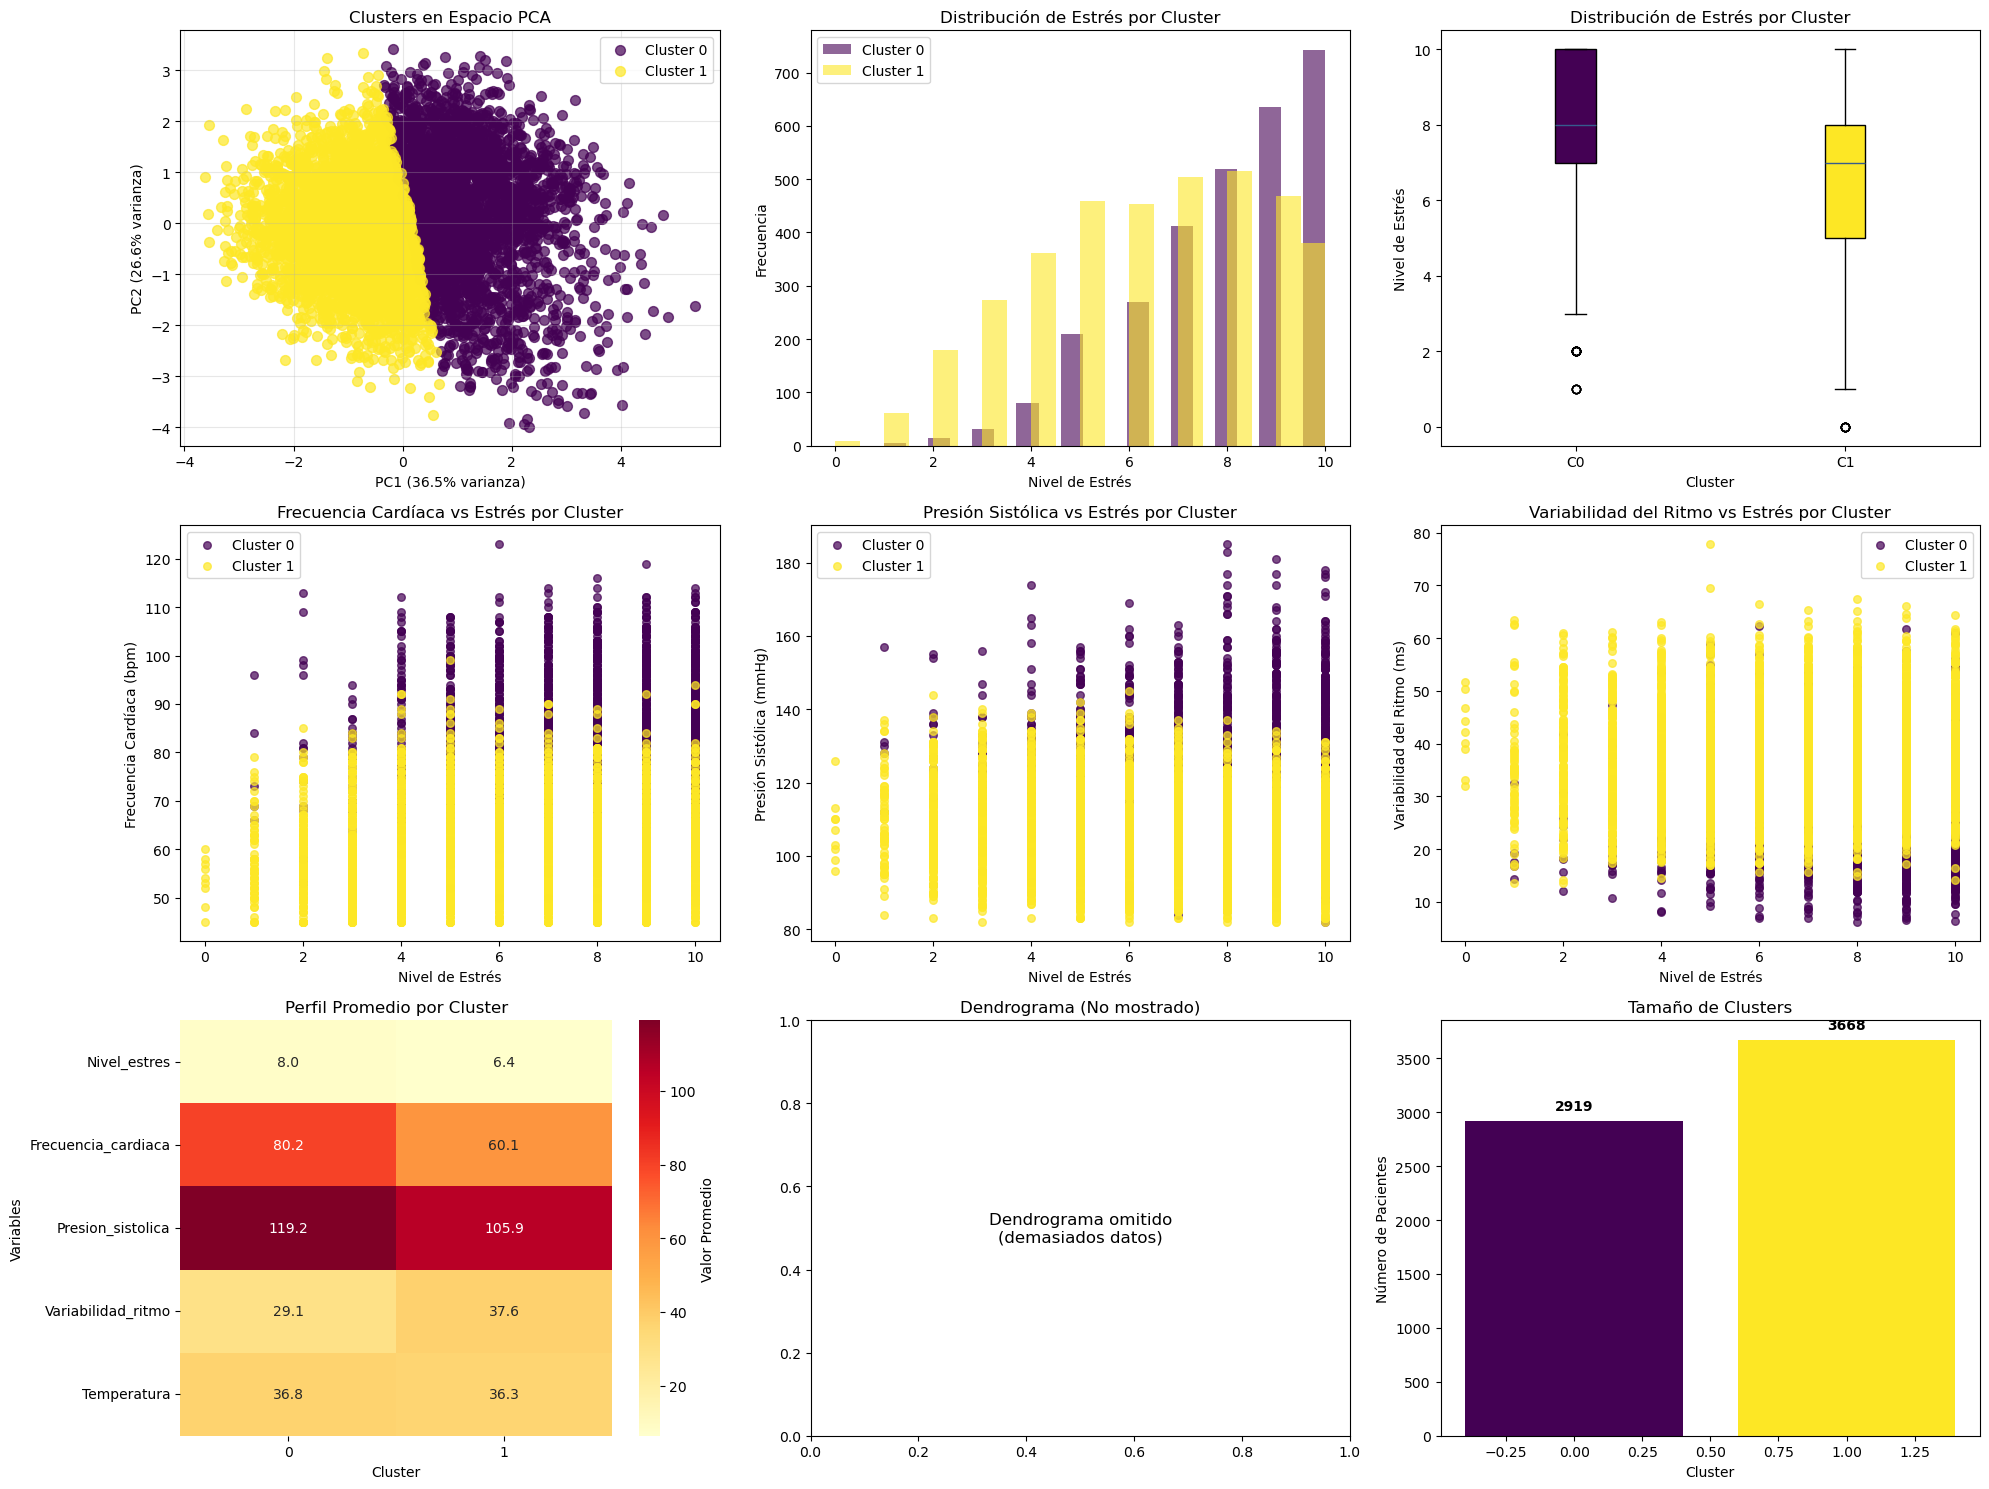

In [34]:
print("ANÁLISIS Y CARACTERIZACIÓN DE CLUSTERS")
print("="*60)

# Agregar cluster final al DataFrame
df_estres_clustered['Cluster_Final'] = clusters_finales

# Estadísticas por cluster
print(" Estadísticas descriptivas por cluster:")
cluster_stats = df_estres_clustered.groupby('Cluster_Final')[variables_estres].agg(['mean', 'std', 'count'])

for cluster in sorted(df_estres_clustered['Cluster_Final'].unique()):
    print(f"\n   🔸 CLUSTER {cluster}:")
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == cluster]
    print(f"      • Número de pacientes: {len(cluster_data)}")
    print(f"      • Porcentaje del total: {len(cluster_data)/len(df_estres_clustered)*100:.1f}%")
    
    for var in variables_estres:
        mean_val = cluster_data[var].mean()
        std_val = cluster_data[var].std()
        print(f"      • {var}: {mean_val:.1f} ± {std_val:.1f}")

# Gráfico 3: Visualización de clusters en 2D usando PCA
print("\n Generando visualizaciones de clusters...")

plt.figure(figsize=(20, 15))

# PCA para reducir dimensionalidad a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Colores para clusters
colors = plt.cm.viridis(np.linspace(0, 1, k_optimal))

# Subplot 1: Clusters en espacio PCA
plt.subplot(3, 3, 1)
for i in range(k_optimal):
    mask = clusters_finales == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], 
               label=f'Cluster {i}', alpha=0.7, s=50)

plt.title('Clusters en Espacio PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Distribución de clusters por nivel de estrés
plt.subplot(3, 3, 2)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.hist(cluster_data['Nivel_estres'], bins=20, alpha=0.6, 
            label=f'Cluster {i}', color=colors[i])

plt.title('Distribución de Estrés por Cluster')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Frecuencia')
plt.legend()

# Subplot 3: Boxplot de nivel de estrés por cluster
plt.subplot(3, 3, 3)
stress_by_cluster = [df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]['Nivel_estres'].values 
                    for i in range(k_optimal)]
box_plot = plt.boxplot(stress_by_cluster, patch_artist=True, labels=[f'C{i}' for i in range(k_optimal)])

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribución de Estrés por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nivel de Estrés')

# Subplot 4: Frecuencia cardíaca vs Nivel de estrés por cluster
plt.subplot(3, 3, 4)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Frecuencia_cardiaca'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Frecuencia Cardíaca vs Estrés por Cluster')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Frecuencia Cardíaca (bpm)')
plt.legend()

# Subplot 5: Presión sistólica vs Nivel de estrés por cluster
plt.subplot(3, 3, 5)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Presion_sistolica'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Presión Sistólica vs Estrés por Cluster')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Presión Sistólica (mmHg)')
plt.legend()

# Subplot 6: Variabilidad del ritmo vs Nivel de estrés por cluster
plt.subplot(3, 3, 6)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Variabilidad_ritmo'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Variabilidad del Ritmo vs Estrés por Cluster')
plt.xlabel('Nivel de Estrés')
plt.ylabel('Variabilidad del Ritmo (ms)')
plt.legend()

# Subplot 7: Heatmap de medias por cluster
plt.subplot(3, 3, 7)
cluster_means = df_estres_clustered.groupby('Cluster_Final')[variables_estres].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valor Promedio'})
plt.title('Perfil Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Variables')

# Subplot 8: Dendrograma (si hay pocos puntos)
plt.subplot(3, 3, 8)
if len(df_estres) <= 1000:  # Solo si hay pocos datos para que sea legible
    # Calcular linkage para dendrograma
    linkage_matrix = linkage(X_scaled, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=3)
    plt.title('Dendrograma (Hierarchical Clustering)')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
else:
    plt.text(0.5, 0.5, 'Dendrograma omitido\n(demasiados datos)', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Dendrograma (No mostrado)')

# Subplot 9: Distribución de tamaños de cluster
plt.subplot(3, 3, 9)
cluster_sizes = df_estres_clustered['Cluster_Final'].value_counts().sort_index()
bars = plt.bar(range(k_optimal), cluster_sizes.values, color=colors)
plt.title('Tamaño de Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Pacientes')

# Agregar etiquetas en las barras
for bar, size in zip(bars, cluster_sizes.values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(cluster_sizes)*0.02, 
             str(size), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### 8. INTERPRETACIÓN MÉDICA DE LOS CLUSTERS

In [37]:
print("INTERPRETACIÓN MÉDICA DE LOS CLUSTERS")
print("="*60)

# Definir nombres interpretativos para cada cluster
cluster_interpretations = {}

for cluster in sorted(df_estres_clustered['Cluster_Final'].unique()):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == cluster]
    
    # Analizar características del cluster
    avg_stress = cluster_data['Nivel_estres'].mean()
    avg_hr = cluster_data['Frecuencia_cardiaca'].mean()
    avg_bp = cluster_data['Presion_sistolica'].mean()
    avg_hrv = cluster_data['Variabilidad_ritmo'].mean()
    avg_temp = cluster_data['Temperatura'].mean()
    
    # Clasificar el tipo de estrés basado en los promedios
    if avg_stress < 25:
        stress_level = "Bajo Estrés"
        risk_level = "Riesgo Mínimo"
        color_code = "🟢"
    elif avg_stress < 50:
        stress_level = "Estrés Moderado"
        risk_level = "Riesgo Bajo-Moderado"
        color_code = "🟡"
    elif avg_stress < 75:
        stress_level = "Alto Estrés"
        risk_level = "Riesgo Alto"
        color_code = "🟠"
    else:
        stress_level = "Estrés Severo"
        risk_level = "Riesgo Crítico"
        color_code = "🔴"
    
    # Analizar respuesta fisiológica
    if avg_hr > 90:
        hr_response = "Taquicardia de estrés"
    elif avg_hr > 80:
        hr_response = "FC ligeramente elevada"
    else:
        hr_response = "FC normal"
    
    if avg_bp > 140:
        bp_response = "Hipertensión por estrés"
    elif avg_bp > 130:
        bp_response = "Presión elevada"
    else:
        bp_response = "Presión normal"
    
    if avg_hrv < 30:
        hrv_response = "Variabilidad reducida (estrés alto)"
    elif avg_hrv < 40:
        hrv_response = "Variabilidad moderada"
    else:
        hrv_response = "Variabilidad saludable"
    
    # Generar interpretación
    interpretation = {
        'nombre': f"{color_code} {stress_level}",
        'n_pacientes': len(cluster_data),
        'porcentaje': len(cluster_data)/len(df_estres_clustered)*100,
        'caracteristicas': {
            'nivel_estres': avg_stress,
            'frecuencia_cardiaca': avg_hr,
            'presion_sistolica': avg_bp,
            'variabilidad_ritmo': avg_hrv,
            'temperatura': avg_temp
        },
        'respuesta_fisiologica': {
            'cardiaca': hr_response,
            'presion': bp_response,
            'autonoma': hrv_response
        },
        'riesgo': risk_level,
        'recomendaciones': []
    }
    
    # Generar recomendaciones específicas
    if avg_stress < 25:
        interpretation['recomendaciones'] = [
            "Mantener hábitos saludables actuales",
            "Monitoreo preventivo regular",
            "Ejercicio moderado regular"
        ]
    elif avg_stress < 50:
        interpretation['recomendaciones'] = [
            "Técnicas de relajación y mindfulness",
            "Evaluación de factores estresantes",
            "Ejercicio aeróbico regular"
        ]
    elif avg_stress < 75:
        interpretation['recomendaciones'] = [
            "Intervención psicológica especializada",
            "Técnicas de manejo de estrés avanzadas",
            "Evaluación médica cardiovascular",
            "Posible medicación ansiolítica"
        ]
    else:
        interpretation['recomendaciones'] = [
            "Atención médica inmediata",
            "Evaluación psiquiátrica",
            "Monitoreo cardiovascular continuo",
            "Intervención farmacológica",
            "Terapia intensiva de manejo de estrés"
        ]
    
    cluster_interpretations[cluster] = interpretation

# Mostrar interpretaciones
print("🔍 Interpretación médica de cada cluster:")
for cluster, interp in cluster_interpretations.items():
    print(f"\n{interp['nombre']} (Cluster {cluster}):")
    print(f"    Pacientes: {interp['n_pacientes']} ({interp['porcentaje']:.1f}%)")
    print(f"    Características promedio:")
    print(f"      • Nivel de estrés: {interp['caracteristicas']['nivel_estres']:.1f}")
    print(f"      • Frecuencia cardíaca: {interp['caracteristicas']['frecuencia_cardiaca']:.1f} bpm")
    print(f"      • Presión sistólica: {interp['caracteristicas']['presion_sistolica']:.1f} mmHg")
    print(f"      • Variabilidad del ritmo: {interp['caracteristicas']['variabilidad_ritmo']:.1f} ms")
    print(f"      • Temperatura: {interp['caracteristicas']['temperatura']:.1f}°C")
    
    print(f"    Respuesta fisiológica:")
    print(f"      • Cardíaca: {interp['respuesta_fisiologica']['cardiaca']}")
    print(f"      • Presión arterial: {interp['respuesta_fisiologica']['presion']}")
    print(f"      • Sistema autónomo: {interp['respuesta_fisiologica']['autonoma']}")
    
    print(f"   ⚠️  Nivel de riesgo: {interp['riesgo']}")
    print(f"    Recomendaciones:")
    for rec in interp['recomendaciones']:
        print(f"      • {rec}")

INTERPRETACIÓN MÉDICA DE LOS CLUSTERS
🔍 Interpretación médica de cada cluster:

🟢 Bajo Estrés (Cluster 0):
    Pacientes: 2919 (44.3%)
    Características promedio:
      • Nivel de estrés: 8.0
      • Frecuencia cardíaca: 80.2 bpm
      • Presión sistólica: 119.2 mmHg
      • Variabilidad del ritmo: 29.1 ms
      • Temperatura: 36.8°C
    Respuesta fisiológica:
      • Cardíaca: FC ligeramente elevada
      • Presión arterial: Presión normal
      • Sistema autónomo: Variabilidad reducida (estrés alto)
   ⚠️  Nivel de riesgo: Riesgo Mínimo
    Recomendaciones:
      • Mantener hábitos saludables actuales
      • Monitoreo preventivo regular
      • Ejercicio moderado regular

🟢 Bajo Estrés (Cluster 1):
    Pacientes: 3668 (55.7%)
    Características promedio:
      • Nivel de estrés: 6.4
      • Frecuencia cardíaca: 60.1 bpm
      • Presión sistólica: 105.9 mmHg
      • Variabilidad del ritmo: 37.6 ms
      • Temperatura: 36.3°C
    Respuesta fisiológica:
      • Cardíaca: FC normal
 

### 9. FUNCIÓN PARA CLASIFICAR NUEVOS PACIENTES

In [40]:
print("FUNCIÓN DE CLASIFICACIÓN PARA NUEVOS PACIENTES")
print("="*60)

def clasificar_patron_estres(nivel_estres, frecuencia_cardiaca, presion_sistolica, 
                           variabilidad_ritmo, temperatura):
    """
    Clasifica a un nuevo paciente en uno de los patrones de estrés identificados
    
    Args:
        nivel_estres (float): Nivel de estrés (0-100)
        frecuencia_cardiaca (float): Frecuencia cardíaca en bpm
        presion_sistolica (float): Presión sistólica en mmHg
        variabilidad_ritmo (float): Variabilidad del ritmo en ms
        temperatura (float): Temperatura corporal en °C
    
    Returns:
        dict: Información del cluster y recomendaciones
    """
    
    # Crear array con los nuevos datos
    nuevos_datos = np.array([[nivel_estres, frecuencia_cardiaca, presion_sistolica, 
                             variabilidad_ritmo, temperatura]])
    
    # Normalizar usando el mismo scaler
    nuevos_datos_scaled = scaler.transform(nuevos_datos)
    
    # Predecir cluster
    cluster_predicho = kmeans.predict(nuevos_datos_scaled)[0]
    
    # Obtener interpretación del cluster
    interpretacion = cluster_interpretations[cluster_predicho]
    
    # Calcular distancia a centroide del cluster
    centroide = kmeans.cluster_centers_[cluster_predicho]
    distancia = np.linalg.norm(nuevos_datos_scaled[0] - centroide)
    
    # Calcular confianza (mayor distancia = menor confianza)
    confianza = max(0, 1 - (distancia / 2))  # Normalizar aproximadamente entre 0 y 1
    
    return {
        'cluster': cluster_predicho,
        'nombre_cluster': interpretacion['nombre'],
        'confianza': confianza,
        'caracteristicas_cluster': interpretacion['caracteristicas'],
        'riesgo': interpretacion['riesgo'],
        'recomendaciones': interpretacion['recomendaciones'],
        'distancia_centroide': distancia
    }


FUNCIÓN DE CLASIFICACIÓN PARA NUEVOS PACIENTES


### 10. EJEMPLOS DE CLASIFICACIÓN

In [43]:
print("\n Ejemplos de clasificación de nuevos pacientes:")

# Ejemplo 1: Paciente con bajo estrés
ejemplo_bajo_estres = {
    'nivel_estres': 15,
    'frecuencia_cardiaca': 72,
    'presion_sistolica': 115,
    'variabilidad_ritmo': 45,
    'temperatura': 36.6
}

resultado_bajo = clasificar_patron_estres(**ejemplo_bajo_estres)

print(f"\n Ejemplo 1 - Paciente con signos de bajo estrés:")
print(f"   Datos de entrada:")
for key, value in ejemplo_bajo_estres.items():
    print(f"      • {key}: {value}")

print(f"\n    Resultado de clasificación:")
print(f"      • Cluster: {resultado_bajo['cluster']}")
print(f"      • Patrón: {resultado_bajo['nombre_cluster']}")
print(f"      • Confianza: {resultado_bajo['confianza']:.2f}")
print(f"      • Riesgo: {resultado_bajo['riesgo']}")
print(f"      • Recomendaciones principales:")
for rec in resultado_bajo['recomendaciones'][:2]:
    print(f"         - {rec}")

# Ejemplo 2: Paciente con alto estrés
ejemplo_alto_estres = {
    'nivel_estres': 85,
    'frecuencia_cardiaca': 105,
    'presion_sistolica': 155,
    'variabilidad_ritmo': 22,
    'temperatura': 37.3
}

resultado_alto = clasificar_patron_estres(**ejemplo_alto_estres)

print(f"\n Ejemplo 2 - Paciente con signos de alto estrés:")
print(f"   Datos de entrada:")
for key, value in ejemplo_alto_estres.items():
    print(f"      • {key}: {value}")

print(f"\n    Resultado de clasificación:")
print(f"      • Cluster: {resultado_alto['cluster']}")
print(f"      • Patrón: {resultado_alto['nombre_cluster']}")
print(f"      • Confianza: {resultado_alto['confianza']:.2f}")
print(f"      • Riesgo: {resultado_alto['riesgo']}")
print(f"      • Recomendaciones principales:")
for rec in resultado_alto['recomendaciones'][:3]:
    print(f"         - {rec}")


 Ejemplos de clasificación de nuevos pacientes:

 Ejemplo 1 - Paciente con signos de bajo estrés:
   Datos de entrada:
      • nivel_estres: 15
      • frecuencia_cardiaca: 72
      • presion_sistolica: 115
      • variabilidad_ritmo: 45
      • temperatura: 36.6

    Resultado de clasificación:
      • Cluster: 0
      • Patrón: 🟢 Bajo Estrés
      • Confianza: 0.00
      • Riesgo: Riesgo Mínimo
      • Recomendaciones principales:
         - Mantener hábitos saludables actuales
         - Monitoreo preventivo regular

 Ejemplo 2 - Paciente con signos de alto estrés:
   Datos de entrada:
      • nivel_estres: 85
      • frecuencia_cardiaca: 105
      • presion_sistolica: 155
      • variabilidad_ritmo: 22
      • temperatura: 37.3

    Resultado de clasificación:
      • Cluster: 0
      • Patrón: 🟢 Bajo Estrés
      • Confianza: 0.00
      • Riesgo: Riesgo Mínimo
      • Recomendaciones principales:
         - Mantener hábitos saludables actuales
         - Monitoreo preventivo regu

### 11. RESUMEN Y CONCLUSIONES

In [46]:
print("RESUMEN Y CONCLUSIONES DEL ANÁLISIS NO SUPERVISADO")
print("="*60)

print("✅ Análisis completado exitosamente")
print(f" Resumen del modelo:")
print(f"   • Algoritmo seleccionado: K-Means")
print(f"   • Número de clusters óptimo: {k_optimal}")
print(f"   • Silhouette Score: {silhouette_kmeans:.3f}")
print(f"   • Variables analizadas: {len(variables_estres)}")
print(f"   • Muestras procesadas: {len(df_estres)}")

print(f"\n Patrones de estrés identificados:")
for cluster, interp in cluster_interpretations.items():
    print(f"   • {interp['nombre']}: {interp['n_pacientes']} pacientes ({interp['porcentaje']:.1f}%)")

print(f"\n Insights principales:")
correlations = []
for var in variables_estres[1:]:
    corr = df_estres['Nivel_estres'].corr(df_estres[var])
    correlations.append((var, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"   • Variables más correlacionadas con el estrés:")
for var, corr in correlations[:3]:
    direction = "positiva" if corr > 0 else "negativa"
    print(f"      - {var}: {corr:.3f} (correlación {direction})")

print(f"\n Aplicaciones clínicas:")
print(f"   • Identificación automática de patrones de estrés")
print(f"   • Clasificación de pacientes para tratamiento personalizado")
print(f"   • Monitoreo continuo de poblaciones en riesgo")
print(f"   • Optimización de recursos de salud mental")

print(f"\n Modelo listo para:")
print(f"   • Clasificación de nuevos pacientes")
print(f"   • Integración con sistema de alertas de estrés")
print(f"   • Monitoreo poblacional de estrés")
print(f"   • Generación de recomendaciones personalizadas")

print("\n" + "="*60)
print("¡ANÁLISIS NO SUPERVISADO DE ESTRÉS COMPLETADO!")
print("="*60)

RESUMEN Y CONCLUSIONES DEL ANÁLISIS NO SUPERVISADO
✅ Análisis completado exitosamente
 Resumen del modelo:
   • Algoritmo seleccionado: K-Means
   • Número de clusters óptimo: 2
   • Silhouette Score: 0.225
   • Variables analizadas: 5
   • Muestras procesadas: 6587

 Patrones de estrés identificados:
   • 🟢 Bajo Estrés: 2919 pacientes (44.3%)
   • 🟢 Bajo Estrés: 3668 pacientes (55.7%)

 Insights principales:
   • Variables más correlacionadas con el estrés:
      - Frecuencia_cardiaca: 0.223 (correlación positiva)
      - Temperatura: 0.161 (correlación positiva)
      - Variabilidad_ritmo: -0.065 (correlación negativa)

 Aplicaciones clínicas:
   • Identificación automática de patrones de estrés
   • Clasificación de pacientes para tratamiento personalizado
   • Monitoreo continuo de poblaciones en riesgo
   • Optimización de recursos de salud mental

 Modelo listo para:
   • Clasificación de nuevos pacientes
   • Integración con sistema de alertas de estrés
   • Monitoreo poblaciona